In [1]:
import sys
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os

In [2]:
time_length = 1000
time_step = 0.1
inverse_time_step = 10

In [3]:
def make_cwnd_rtt(input1, input2, file_name):
    with open(file_name) as f:
        content = f.readlines()
    splitter = lambda x: x[:-1].split()
    split_input = list(map(splitter, content))
    time = list(map(lambda x: x[0], split_input))
    new_input1 = list(map(lambda x: x[1], split_input))
    new_input2 = list(map(lambda x: x[2], split_input))
    
    input1 = [float(x) + float(y) for x, y in zip(input1, new_input1)]
    input2 = [float(x) + float(y) for x, y in zip(input2, new_input2)]
    
    return input1, input2

In [4]:
def get_packet_loss(lost_packets, packets):
    packet_loss = []
    j, k = 0 ,0
    prev_i = 0
    for i in np.arange(0.0, time_length, 1):
        lost_num = 0
        packets_num = 0
        while(j < len(lost_packets) and lost_packets[j] < i):
            lost_num += 1
            j += 1
        while(k < len(packets) and packets[k] < i):
            packets_num += 1
            k += 1
        if(packets_num):
            packet_loss.append(lost_num/packets_num)
        else:
            packet_loss.append(0)
            
    return packet_loss

In [5]:
def sum_packet_loss(prev_packet_loss1, prev_packet_loss2, filename):
    with open(filename) as f:
        content = f.readlines()
    split_drop = list(map(lambda x: x[:-1].split(), content))
    drop_data = list(map(lambda x: x if 'd' in x else None, split_drop))
    drop_data = list(filter((None).__ne__, drop_data))

    drop_1 = list(map(lambda x: float(x[1]) if x[7] == '0' else None, drop_data))
    drop_1 = list(filter((None).__ne__, drop_1))

    drop_2 = list(map(lambda x: float(x[1]) if x[7] == '1' else None, drop_data))
    drop_2 = list(filter((None).__ne__, drop_2))
    
    split_packet = list(map(lambda x: x[:-1].split(), content))
    packet_data = list(map(lambda x: x if '+' in x else None, split_packet))
    packet_data = list(filter((None).__ne__, packet_data))

    packet_1 = list(map(lambda x: float(x[1]) if x[2] == '0' and x[3] == '2' else None, packet_data))
    packet_1 = list(filter((None).__ne__, packet_1))

    packet_2 = list(map(lambda x: float(x[1]) if x[2] == '1' and x[3] == '2' else None, packet_data))
    packet_2 = list(filter((None).__ne__, packet_2))
    
    packet_loss1 = get_packet_loss(drop_1, packet_1)
    packet_loss2 = get_packet_loss(drop_2, packet_2)
    
    return [sum(x) for x in zip(packet_loss1, prev_packet_loss1)], [sum(x) for x in zip(packet_loss2, prev_packet_loss2)]

In [6]:
def get_received_packets(filename):
    with open(filename) as f:
        content = f.readlines()
    split_received = list(map(lambda x: x[:-1].split(), content))
    received_data = list(map(lambda x: x if x[0] == 'r' else None, split_received))
    received_data = list(filter((None).__ne__, received_data))

    received_1 = list(map(lambda x: float(x[1]) if x[2] == '3' and x[3] == '4' else None, received_data))
    received_1 = list(filter((None).__ne__, received_1))

    received_2 = list(map(lambda x: float(x[1]) if x[2] == '3' and x[3] == '5' else None, received_data))
    received_2 = list(filter((None).__ne__, received_2))
    
    return received_1, received_2

In [7]:
def get_lost_packets(filename):
    with open(filename) as f:
        content = f.readlines()
    split_lost = list(map(lambda x: x[:-1].split(), content))
    lost_data = list(map(lambda x: x if x[0] == 'd' else None, split_lost))
    lost_data = list(filter((None).__ne__, lost_data))

    lost_1 = list(map(lambda x: float(x[1]) if x[7] == '0' else None, lost_data))
    lost_1 = list(filter((None).__ne__, lost_1))

    lost_2 = list(map(lambda x: float(x[1]) if x[7] == '1' else None, lost_data))
    lost_2 = list(filter((None).__ne__, lost_2))
    
    return lost_1, lost_2

In [8]:
def get_goodput(received, loss):
    goodput = [0] * time_length
    received_idx = 0
    loss_idx = 0
    loss_ended = False

    for t in range(1, time_length+1):
        if (len(loss) == 0):
            loss.append(-1)
            
        t_goodput = 0
        if int(received[received_idx]) > t:
            continue
        while (not loss_ended) and (loss_idx < len(loss) and loss[loss_idx] < t - 1):
            loss_idx += 1
        if loss_idx == len(loss) and received[received_idx] >= loss[loss_idx-1]:
            loss_ended = True
            loss_idx -= 1
            
        while received_idx < len(received) and received[received_idx] < t - 1:
            received_idx += 1
            
        while received_idx < len(received) and (loss_ended or received[received_idx] < loss[loss_idx]) and received[received_idx] < t :
            t_goodput += 1
            received_idx += 1
        goodput[t-1] = t_goodput * 1000 * 8 * inverse_time_step / (10**6)
        if (received_idx == len(received)):
            break
    
    return goodput

In [9]:
def get_goodput_sum(goodput1, goodput2, filename):
    received1, received2 = get_received_packets(filename)
    lost1, lost2 = get_lost_packets(filename)
    new_goodput1 = get_goodput(received1, lost1)
    new_goodput2 = get_goodput(received2, lost2)
    
    goodput1 = [float(x) + float(y) for x, y in zip(goodput1, new_goodput1)]
    goodput2 = [float(x) + float(y) for x, y in zip(goodput2, new_goodput2)]
    
    return goodput1, goodput2

In [10]:
reno_cwnd1 = [0] * time_length * inverse_time_step
reno_cwnd2 = [0] * time_length * inverse_time_step
tahoe_cwnd1 = [0] * time_length * inverse_time_step
tahoe_cwnd2 = [0] * time_length * inverse_time_step
vegas_cwnd1 = [0] * time_length * inverse_time_step
vegas_cwnd2 = [0] * time_length * inverse_time_step

reno_rtt1 = [0] * time_length * inverse_time_step
reno_rtt2 = [0] * time_length * inverse_time_step
tahoe_rtt1 = [0] * time_length * inverse_time_step
tahoe_rtt2 = [0] * time_length * inverse_time_step
vegas_rtt1 = [0] * time_length * inverse_time_step
vegas_rtt2 = [0] * time_length * inverse_time_step

reno_packet_loss1 = [0] * time_length 
reno_packet_loss2 = [0] * time_length
tahoe_packet_loss1 = [0] * time_length 
tahoe_packet_loss2 = [0] * time_length 
vegas_packet_loss1 = [0] * time_length 
vegas_packet_loss2 = [0] * time_length 

reno_goodput1 = [0] * time_length
reno_goodput2 = [0] * time_length
tahoe_goodput1 = [0] * time_length
tahoe_goodput2 = [0] * time_length
vegas_goodput1 = [0] * time_length
vegas_goodput2 = [0] * time_length

for i in range(10):
    os.system('ns reno.tcl')
    os.system('ns tahoe.tcl')
    os.system('ns vegas.tcl')
    
    reno_cwnd1, reno_cwnd2 = make_cwnd_rtt(reno_cwnd1, reno_cwnd2, 'cwnd_reno')
    tahoe_cwnd1, tahoe_cwnd2 = make_cwnd_rtt(tahoe_cwnd1, tahoe_cwnd2, 'cwnd_tahoe')
    vegas_cwnd1, vegas_cwnd2 = make_cwnd_rtt(vegas_cwnd1, vegas_cwnd2, 'cwnd_vegas')
    
    reno_rtt1, reno_rtt2 = make_cwnd_rtt(reno_rtt1, reno_rtt2, 'rtt_reno')
    tahoe_rtt1, tahoe_rtt2 = make_cwnd_rtt(tahoe_rtt1, tahoe_rtt2, 'rtt_tahoe')
    vegas_rtt1, vegas_rtt2 = make_cwnd_rtt(vegas_rtt1, vegas_rtt2, 'rtt_vegas')
    
    reno_packet_loss1, reno_packet_loss2 = sum_packet_loss(reno_packet_loss1, 
                                                           reno_packet_loss2, 'trace_reno.tr')
    tahoe_packet_loss1, tahoe_packet_loss2 = sum_packet_loss(tahoe_packet_loss1, 
                                                             tahoe_packet_loss2, 'trace_tahoe.tr')
    vegas_packet_loss1, vegas_packet_loss2 = sum_packet_loss(vegas_packet_loss1,
                                                             vegas_packet_loss2, 'trace_vegas.tr')
    
    reno_goodput1, reno_goodput2 = get_goodput_sum(reno_goodput1, reno_goodput2, 'trace_reno.tr')
    tahoe_goodput1, tahoe_goodput2 = get_goodput_sum(tahoe_goodput1, tahoe_goodput2, 'trace_tahoe.tr')
    vegas_goodput1, vegas_goodput2 = get_goodput_sum(vegas_goodput1, vegas_goodput2, 'trace_vegas.tr')
    break

reno_cwnd1 = [x / 10 for x in reno_cwnd1]  
tahoe_cwnd1 = [x / 10 for x in tahoe_cwnd1] 
vegas_cwnd1 = [x / 10 for x in vegas_cwnd1] 
reno_cwnd2 = [x / 10 for x in reno_cwnd2]  
tahoe_cwnd2 = [x / 10 for x in tahoe_cwnd2] 
vegas_cwnd2 = [x / 10 for x in vegas_cwnd2] 

reno_rtt1 = [x / 10 for x in reno_rtt1]
tahoe_rtt1 = [x / 10 for x in tahoe_rtt1]
vegas_rtt1 = [x / 10 for x in vegas_rtt1]
reno_rtt2 = [x / 10 for x in reno_rtt2]
tahoe_rtt2 = [x / 10 for x in tahoe_rtt2]
vegas_rtt2 = [x / 10 for x in vegas_rtt2]

reno_packet_loss1 = [x/10 for x in reno_packet_loss1]
tahoe_packet_loss1 = [x/10 for x in tahoe_packet_loss1]
vegas_packet_loss1 = [x/10 for x in vegas_packet_loss1]
reno_packet_loss2 = [x/10 for x in reno_packet_loss2]
tahoe_packet_loss2 = [x/10 for x in tahoe_packet_loss2]
vegas_packet_loss2 = [x/10 for x in vegas_packet_loss2]

reno_goodput1 = [x/10 for x in reno_goodput1]
tahoe_goodput1 = [x/10 for x in tahoe_goodput1]
vegas_goodput1 = [x/10 for x in vegas_goodput1]
reno_goodput2 = [x/10 for x in reno_goodput2]
tahoe_goodput2 = [x/10 for x in tahoe_goodput2]
vegas_goodput2 = [x/10 for x in vegas_goodput2]

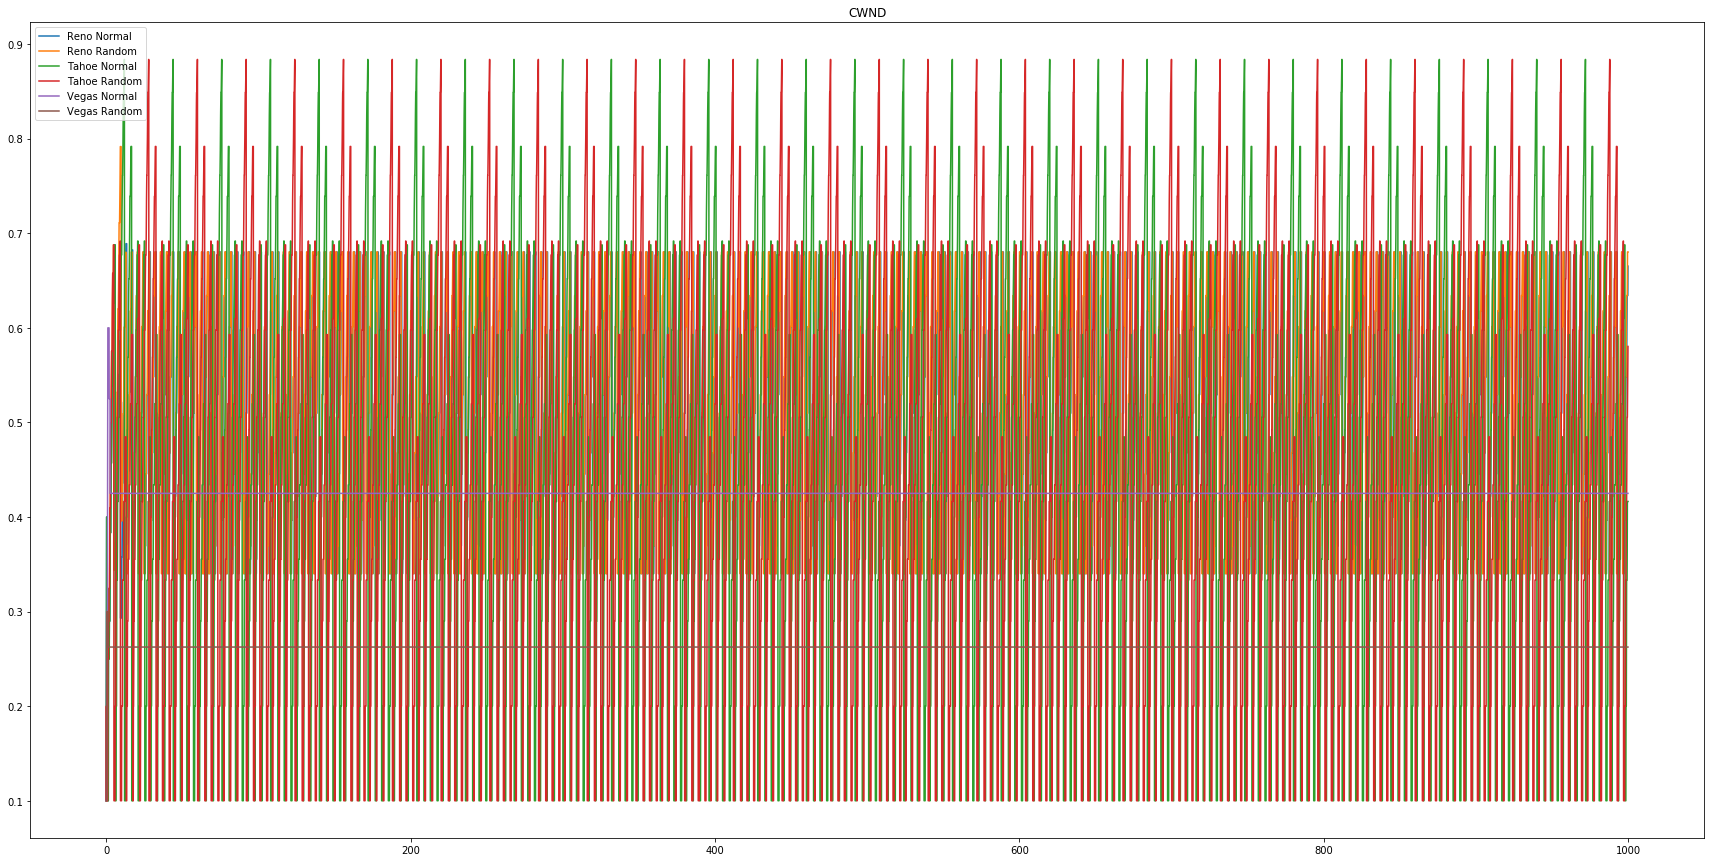

In [11]:
plt.figure(figsize=(30,15))
plt.plot(np.arange(0, time_length, time_step), reno_cwnd1)
plt.plot(np.arange(0, time_length, time_step), reno_cwnd2)
plt.plot(np.arange(0, time_length, time_step), tahoe_cwnd1)
plt.plot(np.arange(0, time_length, time_step), tahoe_cwnd2)
plt.plot(np.arange(0, time_length, time_step), vegas_cwnd1)
plt.plot(np.arange(0, time_length, time_step), vegas_cwnd2)
plt.legend(['Reno Normal', 'Reno Random','Tahoe Normal', 'Tahoe Random',
           'Vegas Normal', 'Vegas Random'], loc='upper left')
plt.title('CWND')
plt.show()

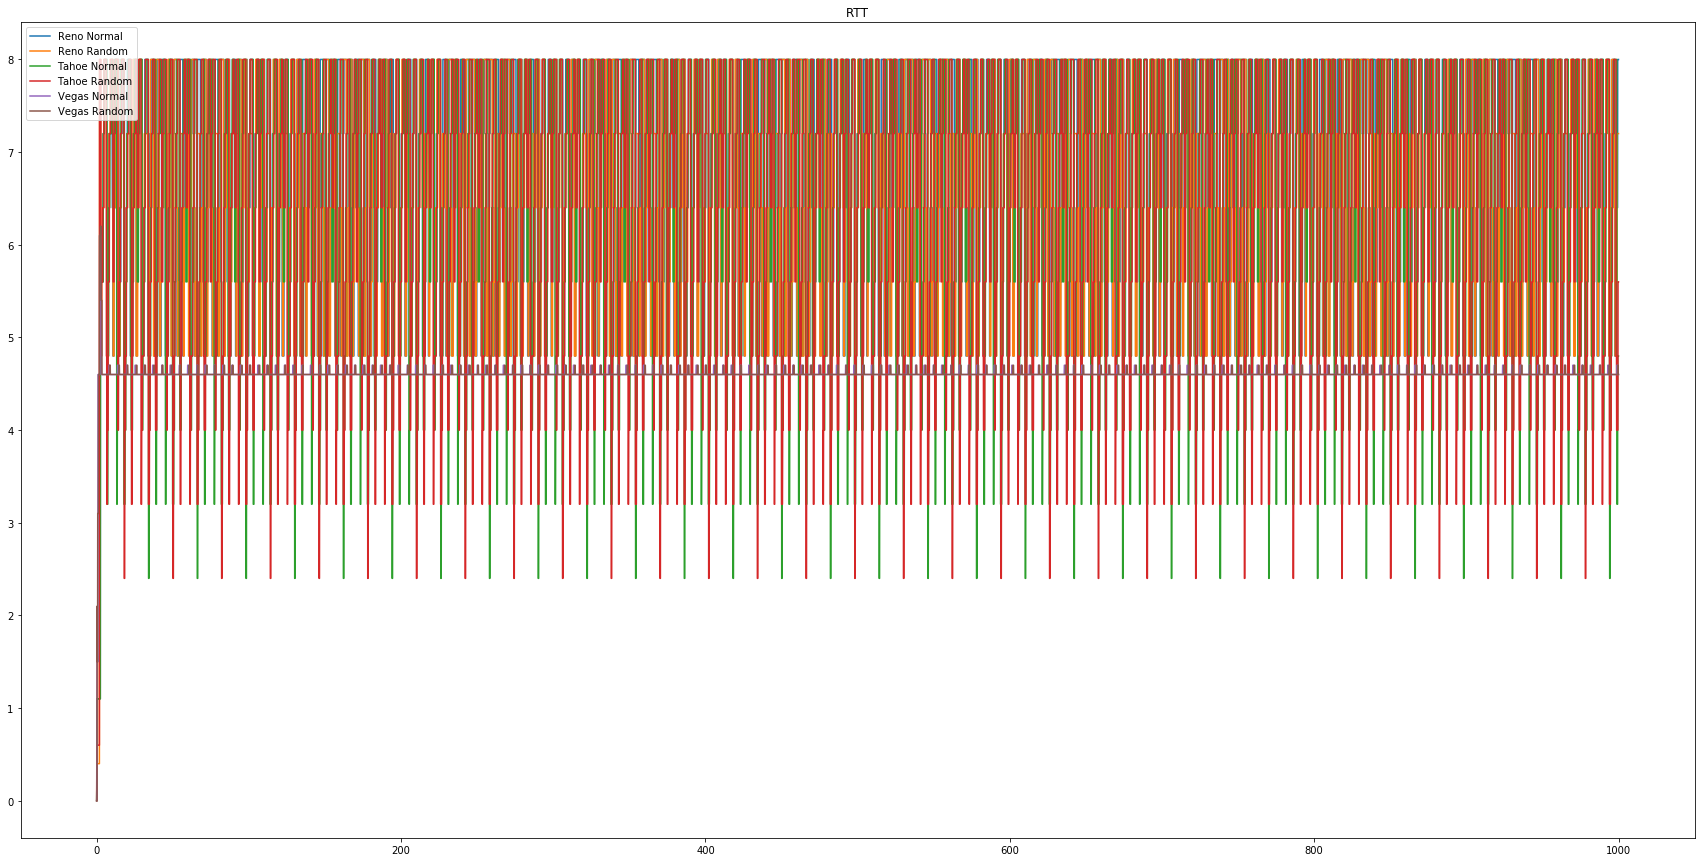

In [12]:
plt.figure(figsize=(30,15))
plt.plot(np.arange(0, time_length, 0.1), reno_rtt1)
plt.plot(np.arange(0, time_length, 0.1), reno_rtt2)
plt.plot(np.arange(0, time_length, 0.1), tahoe_rtt1)
plt.plot(np.arange(0, time_length, 0.1), tahoe_rtt2)
plt.plot(np.arange(0, time_length, 0.1), vegas_rtt1)
plt.plot(np.arange(0, time_length, 0.1), vegas_rtt2)
plt.legend(['Reno Normal', 'Reno Random', 'Tahoe Normal', 'Tahoe Random',
           'Vegas Normal', 'Vegas Random'], loc='upper left')
plt.title('RTT')
plt.show()

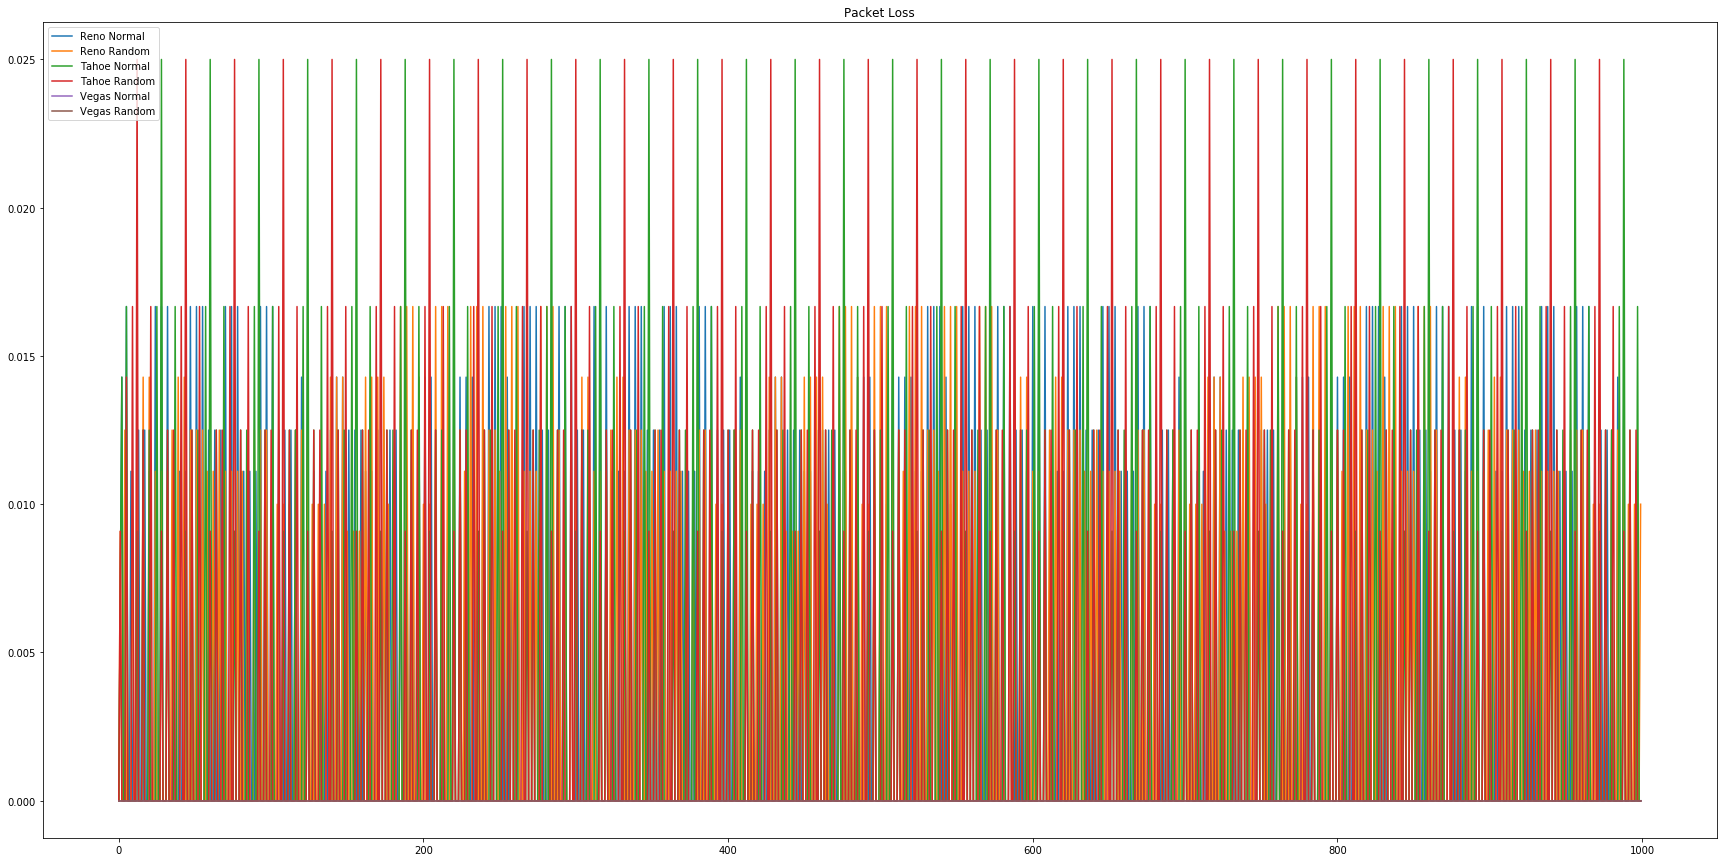

In [13]:
plt.figure(figsize=(30,15))
plt.plot(np.arange(time_length), reno_packet_loss1)
plt.plot(np.arange(time_length), reno_packet_loss2)
plt.plot(np.arange(time_length), tahoe_packet_loss1)
plt.plot(np.arange(time_length), tahoe_packet_loss2)
plt.plot(np.arange(time_length), vegas_packet_loss1)
plt.plot(np.arange(time_length), vegas_packet_loss2)

plt.legend(['Reno Normal', 'Reno Random', 'Tahoe Normal', 'Tahoe Random',
           'Vegas Normal', 'Vegas Random'], loc='upper left')
plt.title('Packet Loss')
plt.show()

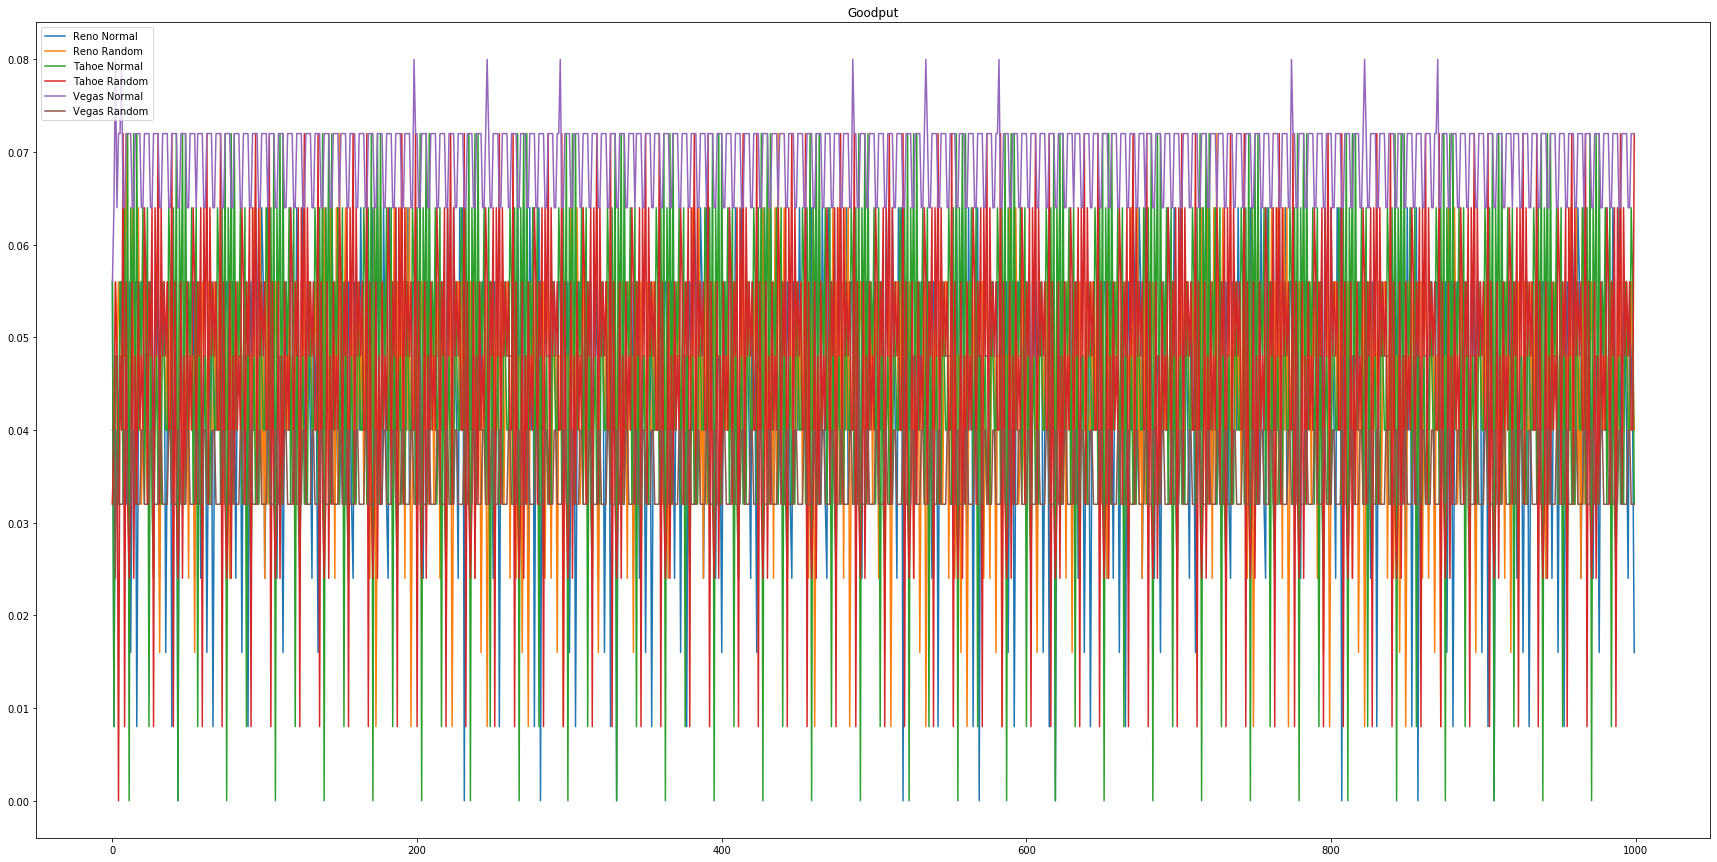

In [14]:
plt.figure(figsize=(30,15))
plt.plot(np.arange(time_length), reno_goodput1)
plt.plot(np.arange(time_length), reno_goodput2)
plt.plot(np.arange(time_length), tahoe_goodput1)
plt.plot(np.arange(time_length), tahoe_goodput2)
plt.plot(np.arange(time_length), vegas_goodput1)
plt.plot(np.arange(time_length), vegas_goodput2)

plt.legend(['Reno Normal', 'Reno Random', 'Tahoe Normal', 'Tahoe Random',
           'Vegas Normal', 'Vegas Random'], loc='upper left')
plt.title('Goodput')
plt.show()